# Import

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_absolute_error, mean_squared_error, classification_report, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE




# Load Dataset

In [21]:
data = pd.read_csv('../../Data/DataLaba2/neo_task.csv').dropna()
data['name'] = pd.factorize(data['name'])[0]
data


,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3561024.0,0,0.016016,0.035813,56014.078517,1.024333e+06,26.10,False
1,54016766.0,1,0.030518,0.068240,7864.348060,3.268186e+07,24.70,False
2,3746620.0,2,0.055533,0.124177,55257.544508,6.538636e+07,23.40,False
3,3633054.0,3,0.019256,0.043057,41531.404722,1.260796e+07,25.70,False
4,3742124.0,4,0.139494,0.311918,67639.394481,7.130590e+07,21.40,False
...,...,...,...,...,...,...,...,...
90831,54231436.0,27136,0.017561,0.039268,23264.740825,1.635007e+06,25.90,False
90832,3824972.0,7446,0.110804,0.247765,24802.519406,3.351901e+07,21.90,False
90833,3740101.0,8402,0.035039,0.078350,116288.999548,5.471396e+07,24.40,False
90834,3691093.0,18852,0.044112,0.098637,45763.317060,2.694877e+07,23.90,False


# Normalise data

In [22]:
mm_scaler = MinMaxScaler()
data_scaled = mm_scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
# data_scaled['date'] = data['date']
# data_scaled
data_scaled_x, hazardous = SMOTE().fit_resample(data_scaled.drop(['hazardous'], axis=1), data['hazardous'])
# data_scaled_x = data.drop(['Appliances', 'date'], axis=1)



In [23]:
data_scaled_x

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.029853,0.000000,0.000407,0.000407,0.235700,0.013606,0.703796
1,0.995043,0.000037,0.000789,0.000789,0.032354,0.436880,0.645390
2,0.033404,0.000074,0.001450,0.001450,0.232505,0.874154,0.591156
3,0.031231,0.000111,0.000492,0.000492,0.174537,0.168484,0.687109
4,0.033318,0.000147,0.003665,0.003665,0.284797,0.953300,0.507718
...,...,...,...,...,...,...,...
159883,0.007631,0.020730,0.012373,0.012373,0.236360,0.581684,0.397923
159884,0.000296,0.580504,0.037407,0.037407,0.332303,0.867581,0.297647
159885,0.030872,0.402664,0.004185,0.004185,0.217943,0.481212,0.495767
159886,0.020922,0.302992,0.003888,0.003888,0.240784,0.116926,0.502558


# Power data

In [24]:
p = PolynomialFeatures(1)
data_scaled_powered_x = p.fit_transform(data_scaled_x)
data_scaled_powered_x.shape
# data_scaled_powered_x = data_scaled_x.to_numpy()

(159888, 8)

# VarianceThreshold feature select

In [25]:
data_scaled_powered_x.mean(axis=0).shape

(8,)

In [26]:
data_thresh_remove = []
td = []
for i in data_scaled_powered_x.std(axis=0)**2:
    try:
        skb = VarianceThreshold(i)
        data_thresh_remove.append(skb.fit_transform(data_scaled_powered_x, hazardous))
        td.append(i)
        # X_vt.shape
        # print(f'{i}-')
    except ValueError:
        print(i)


0.12170639787962304


# Predictors

In [27]:
ridge_optimal_for_line_regressions = []
data_splits = []
for d in data_thresh_remove:
    X_train, X_test, y_train, y_test = train_test_split(d, hazardous, test_size=0.2)
    data_splits.append({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})
    # x = RandomizedSearchCV(SVC(), {'kernel': ['linear', 'poly', ]}, n_iter=5,
    #                        n_jobs=3,
    #                        scoring='f1',
    #                        random_state=71).fit(X_train, y_train)
    x = GaussianNB().fit(X_train, y_train)
    ridge_optimal_for_line_regressions.append(x)
    # print(1)
# ridge_optimal_for_line_regression.best_params_


In [28]:
# print([r.best_params_ for r in ridge_optimal_for_line_regressions])


In [29]:
len(ridge_optimal_for_line_regressions), len(data_splits), len(td)


(7, 7, 7)

# Result Analize

In [30]:
def res(y_predicted, y_test):
    print(#f"MAE: {mean_absolute_error(y_predicted, y_test)}",
        #   f'RMSE: {mean_squared_error(y_predicted, y_test)}',
          f'MSE: {accuracy_score(y_predicted, y_test)}',
          f'MAPE: {recall_score(y_predicted, y_test)}',
          f'R^2: {f1_score(y_predicted, y_test)}',
          sep='\n')


In [31]:
i = 0
ridge_optimal_for_line_regressions[i].predict(data_splits[i]['X_test']).shape, data_splits[i]['y_test']


((31978,),
 113003     True
 148322     True
 73624     False
 44043     False
 84945     False
           ...  
 85521     False
 80782     False
 121534     True
 134973     True
 1509      False
 Name: hazardous, Length: 31978, dtype: bool)

In [32]:
for i, m, d in zip(td, ridge_optimal_for_line_regressions, data_splits):
    print(f'{i}) ' + '<>'*20)
    res(m.predict(d['X_test']), d['y_test'])
    print('\n')
    

0.0) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.8371067608981174
MAPE: 0.7911805629883335
R^2: 0.8502170975069729


0.06370034460940803) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.5803677528300707
MAPE: 0.5473982483256054
R^2: 0.6891519377330955


6.082122268405461e-05) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.8341985114766401
MAPE: 0.7863690283619109
R^2: 0.8461850884827387


6.0821222683901754e-05) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.8379510913753205
MAPE: 0.7884338121428953
R^2: 0.8507144503341784


0.012788903605418744) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.831759334542498
MAPE: 0.7818229854689565
R^2: 0.8461626444012352


0.08522296506890971) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.5787103633748202
MAPE: 0.5461058045554739
R^2: 0.6881625850655063


0.013718813274209526) <><><><><><><><><><><><><><><><><><><><>
MSE: 0.5919694790168241
MAPE: 0.5584167494460152
R^2: 0.6913907284768211




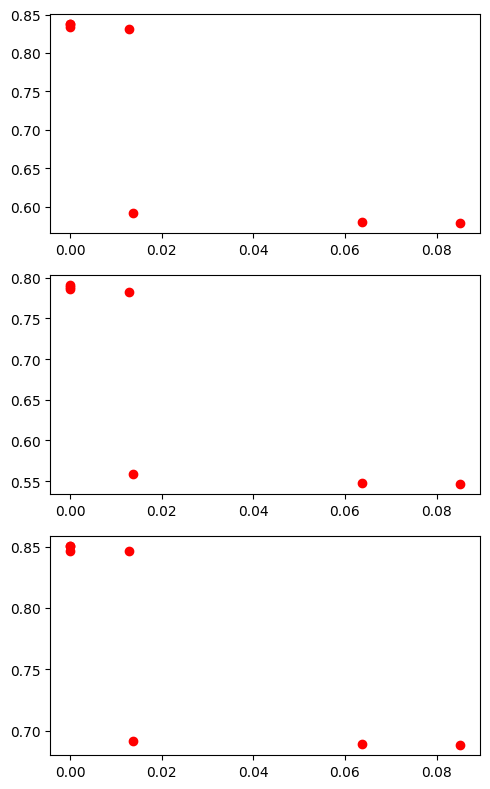

In [33]:
scores = [accuracy_score, recall_score, f1_score]
fig = plt.figure(tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(5)
gs = gridspec.GridSpec(len(scores), 1)
for s in range(len(scores)):
    x = []
    y = []  
    for i, m, d in zip(td, ridge_optimal_for_line_regressions, data_splits):
        x.append(i)
        y.append(scores[s](m.predict(d['X_test']), d['y_test']))
        # print(x, y)
    ax = fig.add_subplot(gs[s, 0])
    ax.scatter(x, y, c='red')


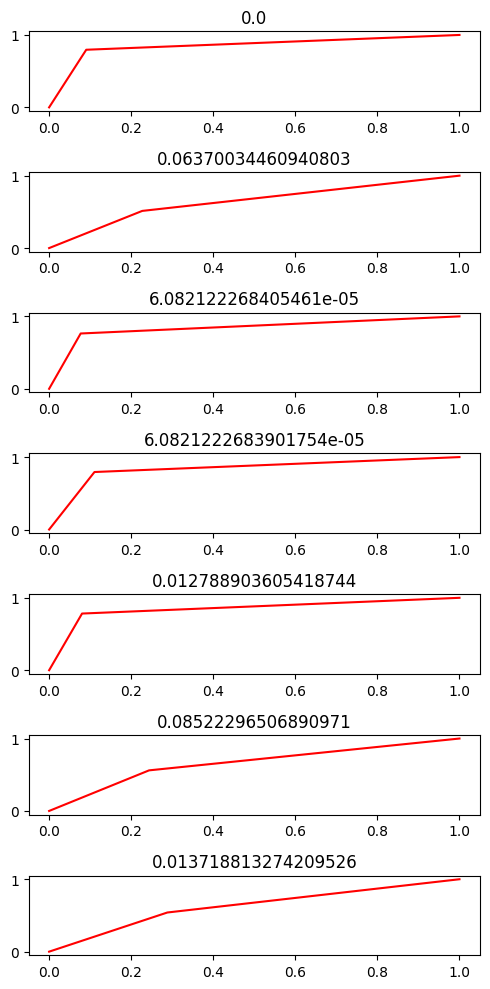

In [34]:
fig = plt.figure(tight_layout=True)
fig.set_figheight(10)
fig.set_figwidth(5)
gs = gridspec.GridSpec(len(ridge_optimal_for_line_regressions), 1)

for i, s, m, d in zip(range(len(ridge_optimal_for_line_regressions)), td, ridge_optimal_for_line_regressions, data_splits):
    ax = fig.add_subplot(gs[i, 0])
    # ax.scatter(m, d['y_test'], c='red')
    fpr, tpr, thresholds = roc_curve(m.predict(d['X_test'][:1000]), d['y_test'][:1000])
    roc_auc = auc(fpr, tpr)
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    # display.plot()
    ax.plot(fpr, tpr, c='red')
    ax.set_title(s)
